In [ ]:
%pip install -r langgraph-requirements.txt --quiet --upgrade

In [ ]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

# Multi-Agent Support Ticket System with LangGraph

This notebook demonstrates building a multi-agent system for triaging and resolving support tickets using LangGraph and AWS Bedrock.

## Import necessary libraries

In [1]:
# Import necessary libraries
import json
from typing import TypedDict, List, Dict, Any
from textwrap import dedent

# LangChain imports
from langchain_aws import ChatBedrock
from langchain.tools import tool

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

## Set up the LLM

Configure the AWS Bedrock model for our agents.

In [2]:
# Set up the LLM
model = ChatBedrock(
    model="us.amazon.nova-pro-v1:0",
    temperature=0.1,
    region="us-west-2"
)

## Define the State Type

Create a TypedDict to represent the state of a support ticket.

In [3]:
# Define the State type
class TicketState(TypedDict):
    ticket_id: str
    content: str
    category: str
    status: str
    history: List[Dict[str, Any]]
    current_agent: str
    resolution: str
    requires_human: bool
    next: str
    messages: List[Dict[str, Any]]

## Tool Definitions

Define the tools that our agents will use to process support tickets.

In [4]:
# Tool definitions
@tool
def search_kb_tool(query: str) -> str:
    """Search knowledge base for relevant information about the query"""
    # Mock implementation - would connect to actual KB in production
    kb = {
        "password reset": "Users can reset passwords at example.com/reset",
        "account locked": "Accounts are locked after 3 failed attempts",
        "billing": "Billing cycles occur on the 1st of each month",
        "features": "New features are documented at example.com/features"
    }
    
    for keyword, info in kb.items():
        if keyword in query.lower():
            return info
    return "No relevant information found in knowledge base."

@tool
def get_ticket_history_tool(ticket_id: str) -> str:
    """Get the history of a support ticket"""
    # Mock implementation
    return f"Retrieved history for ticket {ticket_id}: No previous interactions found."

@tool
def check_account_status_tool(account_id: str) -> str:
    """Check status of a user account"""
    # Mock implementation
    statuses = {"default": "active"}
    return f"Account status: {statuses.get(account_id, 'active')}"

@tool
def reset_password_tool(account_id: str) -> str:
    """Initiate password reset for an account"""
    # Mock implementation
    return f"Password reset initiated for account {account_id}. Reset email sent."

@tool
def unlock_account_tool(account_id: str) -> str:
    """Unlock a locked user account"""
    # Mock implementation
    return f"Account {account_id} has been unlocked. User can now log in."

@tool
def search_documentation_tool(query: str) -> str:
    """Search product documentation"""
    # Mock implementation
    docs = {
        "login": "Login documentation: Go to example.com and click 'Sign In'",
        "features": "Feature documentation available at example.com/features",
        "api": "API documentation available at example.com/api",
        "settings": "Settings can be configured at example.com/settings"
    }
    
    for keyword, info in docs.items():
        if keyword in query.lower():
            return info
    return "No relevant documentation found."

@tool
def generate_how_to_tool(topic: str) -> str:
    """Generate a how-to guide for a common task"""
    # Mock implementation
    how_tos = {
        "password": "How to reset your password:\n1. Go to login page\n2. Click 'Forgot Password'\n3. Enter email\n4. Follow instructions in email",
        "account": "How to manage your account:\n1. Log in\n2. Click 'Account' in top menu\n3. Select desired option",
        "billing": "How to update billing information:\n1. Log in\n2. Go to Settings > Billing\n3. Click 'Update Payment Method'"
    }
    
    for keyword, guide in how_tos.items():
        if keyword in topic.lower():
            return guide
    return f"How-to guide for {topic}:\n1. Log in to your account\n2. Check the help section\n3. Contact support if needed"

@tool
def prep_for_human_tool(ticket_content: str) -> str:
    """Prepare a ticket for human review"""
    # Mock implementation
    return "Ticket prepared for human review with relevant context and history."

@tool
def get_escalation_priority_tool(ticket_content: str) -> str:
    """Determine the priority level for escalation"""
    # Mock implementation
    if "urgent" in ticket_content.lower() or "immediately" in ticket_content.lower():
        return "high"
    elif "soon" in ticket_content.lower() or "important" in ticket_content.lower():
        return "medium"
    else:
        return "low"

## Create the Agents

Define specialized agents for different aspects of ticket processing.

The first agent will be a classifier agent: its task is to take the ticket as input and route it to the right category.

In [5]:
# Entry point: Classifier Agent
classifier_agent = create_react_agent(
    name="classifier_agent",
    model=model,
    tools=[],
    prompt=dedent("""
    You are a support ticket classifier.
    Your task is to analyze the content of a support ticket and classify it into one of the following categories:
    - account_issue (login problems, password resets, account locks)
    - documentation_help (how to use, documentation questions)
    - technical_problem (bugs, errors, technical difficulties)
    - other (any other issues not covered by the above categories)
    Your final answer should be the category name only.
    """)
)
def classify_issue(state):
    classification = classifier_agent.invoke(state)['messages'][-1].content
    state["next"] = classification
    return state

In [6]:
account_agent = create_react_agent(
    model=model,
    tools=[check_account_status_tool, reset_password_tool, unlock_account_tool],
    prompt="You are an account management specialist. Your task is to analyze the content of a support ticket and resolve common account issues. Only use the tools provided to you. If you cannot resolve the issue, prepare the ticket for human review.",
)
def solve_account_issue(state):
    response = account_agent.invoke(state)['messages'][-1].content
    state["next"] = "end"
    state["resolution"] = response
    return state

In [7]:
documentation_agent = create_react_agent(
    model=model,
    tools=[search_documentation_tool, generate_how_to_tool],
    prompt=dedent("""\
    You are a documentation expert.
    Find relevant documentation to address the user's question.
    Use the available tools to search documentation.
    Your final answer should be a concise explanation or link to appropriate resources.\
    """),
)
def provide_documentation(state):
    response = documentation_agent.invoke(state)['messages'][-1].content
    state["next"] = "end"
    state["resolution"] = response
    return state

In [8]:
tech_support_agent = create_react_agent(
    model=model,
    tools=[search_kb_tool, get_ticket_history_tool],
    prompt=dedent("""\
    You are a technical support agent.
    Your task is to analyze the content of a support ticket and resolve common technical issues.
    Use the available tools to search knowledge base and retrieve ticket history.
    Your final answer should be a concise explanation or resolution.\
    """),
)
def solve_technical_issue(state):
    response = tech_support_agent.invoke(state)['messages'][-1].content
    state["next"] = "end"
    state["resolution"] = response
    return state

In [9]:
other_agent = create_react_agent(
    model=model,
    tools=[prep_for_human_tool, get_escalation_priority_tool],
    prompt=dedent("""\
    You are a support ticket triage agent.
    Your task is to analyze the content of a support ticket and prepare it for human review.
    Use the available tools to prepare the ticket and determine escalation priority.
    Your final answer should be a concise summary of the ticket and its priority level.\
    """),
)
def handle_other_issue(state):
    response = other_agent.invoke(state)['messages'][-1].content
    state["next"] = "end"
    state["resolution"] = response
    return state

## Build the Graph

Create the workflow graph that defines how tickets are processed.

In [10]:
workflow = StateGraph(TicketState)

# Invoking an agent is done by nodes
workflow.add_node("classify_issue", classify_issue)
workflow.add_node("solve_account_issue", solve_account_issue)
workflow.add_node("doc_support", provide_documentation)
workflow.add_node("tech_support", solve_technical_issue)
workflow.add_node("escalate_issue", handle_other_issue)

# Edges define the flow of the graph
workflow.add_edge(START, "classify_issue")
workflow.add_conditional_edges(
    "classify_issue",
    lambda state: state["next"],
    {
        "account_issue": "solve_account_issue",
        "technical_problem": "tech_support",
        "documentation_help": "doc_support",
        "other": "escalate_issue",
    }
)

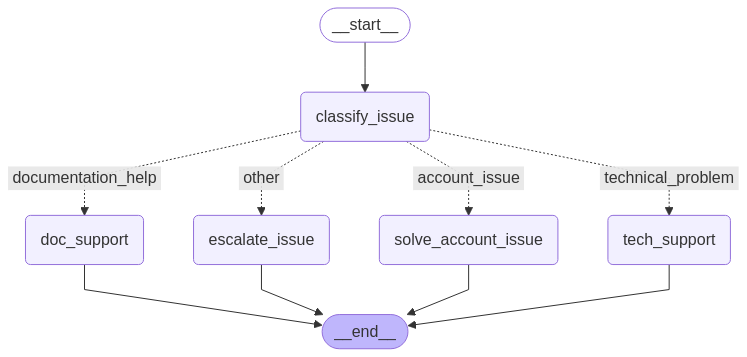

In [11]:
executor = workflow.compile()
executor

## Test the System

Process some sample tickets to test the support system.

In [12]:
executor.invoke(
    {
        "ticket_id": "12345",
        "content": "I can't log in to my account. I think my password is wrong.",
        "category": "",
        "status": "open",
        "history": [],
        "current_agent": "",
        "resolution": "",
        "requires_human": False,
        "next": "",
        "messages": [
            {
                "role": "user",
                "content": "I can't log in to my account. I think my password is wrong."
            }
        ]
    }
)

{'ticket_id': '12345',
 'content': "I can't log in to my account. I think my password is wrong.",
 'category': '',
 'status': 'open',
 'history': [],
 'current_agent': '',
 'resolution': 'A password reset has been initiated for your account. Please check your email for instructions on how to reset your password. If you do not receive the email within a few minutes, please check your spam folder.',
 'requires_human': False,
 'next': 'end',
 'messages': [{'role': 'user',
   'content': "I can't log in to my account. I think my password is wrong."}]}

## Explanation

This notebook demonstrates a multi-agent support ticket system using LangGraph and AWS Bedrock.
The system:
1. Classifies incoming tickets
2. Routes them to specialized agents based on category
3. Attempts automated resolution
4. Escalates to humans when necessary

The state tracking allows us to maintain context across the entire workflow,
and the graph structure makes it easy to modify or extend the system.

To deploy this in a real environment:
1. Replace mock tool implementations with actual API calls
2. Add error handling and retries
3. Implement proper authentication
4. Add monitoring and feedback loops
5. Expand the range of ticket categories and resolution strategies